# Modelos Estocásticos (Cadenas de Markov y Simulación de Monte Carlo)

Este script explora conceptos fundamentales en ciencia de datos y finanzas cuantitativas.

## Objetivos de Aprendizaje
1. **Cadenas de Markov (Teoría):** Entender la "pérdida de memoria" del sistema y la convergencia al equilibrio.
2. **Simulación de Montecarlo (Proyección):** Usar la fuerza bruta computacional para ver miles de futuros posibles.
3. **Aplicación Real (Fusión):** Extraer una Cadena de Markov de datos reales del mercado.
4. **Stress Testing:** Simular un "Cisne Negro" usando Cadenas de Markov No Homogéneas.
5. **Predicción Analítica (Matemática Pura):** Usar álgebra lineal para calcular probabilidades condicionales exactas (Chapman-Kolmogorov).



In [1]:
# Instalación de librerías necesarias
!pip install numpy pandas matplotlib seaborn yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as sps

# Configuración de estilo visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Parte 1: Cadenas de Markov (Concepto Base)

Una Cadena de Markov es un sistema con "amnesia". Para predecir el futuro, **solo importa dónde estás hoy**, no importa la historia de cómo llegaste allí.

Vamos a modelar la competencia entre 3 marcas (A, B, C).
* **Estado Estacionario:** Es la "magia" de Markov. Sin importar si empiezas con el 100% de clientes, el sistema se estabilizará en proporciones naturales definidas por la matriz de transición.

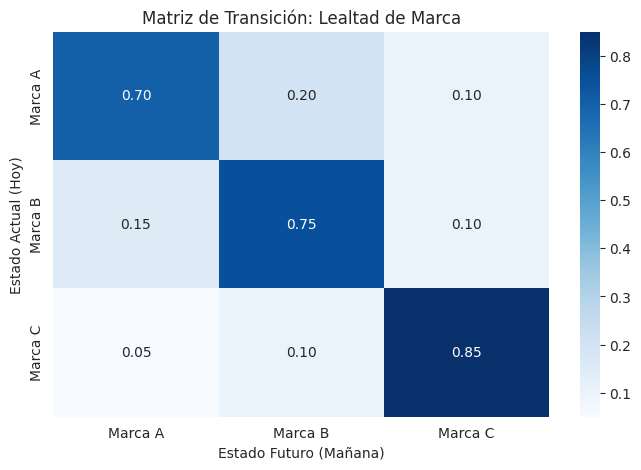

In [3]:
# 1. Definir la Matriz de Transición (Probabilidades de cambio)
# Fila = Estado Actual. Columna = Estado Futuro.
# Ejemplo: Fila 0, Columna 1 es la prob. de pasar de A -> B.

P = np.array([
    [0.70, 0.20, 0.10],  # De A -> [A, B, C]
    [0.15, 0.75, 0.10],  # De B -> [A, B, C]
    [0.05, 0.10, 0.85]   # De C -> [A, B, C]
])

marcas = ['Marca A', 'Marca B', 'Marca C']

# Visualizar la dinámica
plt.figure(figsize=(8, 5))
sns.heatmap(P, annot=True, cmap="Blues", xticklabels=marcas, yticklabels=marcas, fmt=".2f")
plt.title("Matriz de Transición: Lealtad de Marca")
plt.ylabel("Estado Actual (Hoy)")
plt.xlabel("Estado Futuro (Mañana)")
plt.show()

### Interpretación

Este gráfico es la **huella digital** del comportamiento del consumidor. No son solo números, es una historia de **Lealtad vs. Fuga**.

1.  **La Diagonal Principal:**
    * Mira los cuadros azul oscuro en diagonal: **0.70, 0.75, 0.85**.
    * Esto representa la probabilidad de que un cliente se **Quede** con la marca.
    * **Conclusión:** La **Marca C** es la más fuerte (85% de retención), es un "castillo". La **Marca A** es la más débil (solo retiene al 70%).

2.  **Fuera de la Diagonal:**
    * Mira la celda **(Marca A, Marca B) = 0.20**.
    * Significa que la Marca A está "sangrando" clientes: el 20% de sus usuarios se van a la Marca B en cada periodo.
    * Esto es una alerta roja para el equipo de marketing de A.

### Simulación de Convergencia
Observa cómo las líneas se aplanan al final. Ese es el **Equilibrio**.

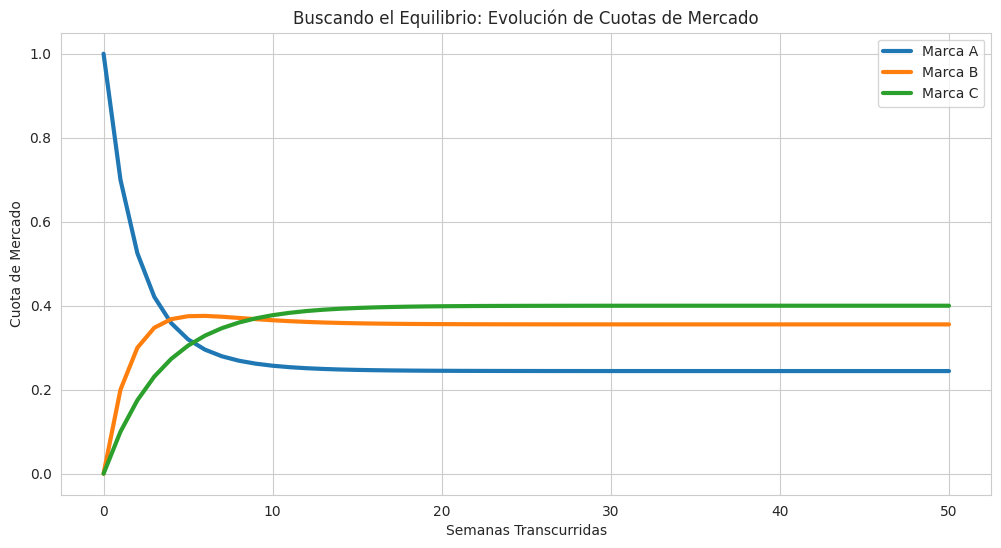

In [4]:
# Estado inicial: Monopolio de A (100% mercado)
estado_actual = np.array([1.0, 0.0, 0.0])

historia_mercado = [estado_actual]
semanas = 50

for t in range(semanas):
    estado_actual = np.dot(estado_actual, P)
    historia_mercado.append(estado_actual)

df_markov = pd.DataFrame(historia_mercado, columns=marcas)

plt.figure(figsize=(12, 6))
for marca in marcas:
    plt.plot(df_markov[marca], label=marca, linewidth=3)

plt.title("Buscando el Equilibrio: Evolución de Cuotas de Mercado")
plt.xlabel("Semanas Transcurridas")
plt.ylabel("Cuota de Mercado")
plt.legend()
plt.show()

### Convergencia

Este gráfico revela la **dinámica de poder** en el tiempo:

1.  **El Desplome de A (Azul):**
    * Empieza en 1.0 (100% del mercado) y cae en picada.
    * **Insight:** No importa cuán grande seas hoy, si tu retención es baja (70%), el mercado te castigará hasta encontrar tu nivel natural (~25%).

2.  **El Ascenso de C (Verde):**
    * Empieza en 0.0 (Nadie la conoce) pero termina dominando (~40%).
    * **Insight:** La **Lealtad paga**. Aunque C sea pequeña al inicio, su alta retención (85%) actúa como un interés compuesto, acumulando usuarios hasta ser líder.

3.  **El Punto de Olvido:**
    * Fíjate alrededor de la **Semana 15**. Las líneas dejan de moverse.
    * Aquí el sistema ha "olvidado" que A era un monopolio. Ha alcanzado el **Estado Estacionario**. Cualquier esfuerzo de marketing de corto plazo se diluirá eventualmente hacia estos niveles si no cambias la matriz P (el producto/servicio).

# Parte 2: Simulación de Montecarlo
### Proyectando la Incertidumbre del Dólar

Aquí cambiamos de enfoque. Asumimos que el precio se mueve aleatoriamente siguiendo una **Distribución Normal** (Caminata Aleatoria).
Usaremos datos reales para obtener la **Media** (tendencia) y la **Desviación Estándar** (riesgo).

In [5]:
# Descargar datos reales
ticker = "COP=X"
try:
    datos = yf.download(ticker, period="2y", interval="1d", progress=False)
    # Ajuste de compatibilidad para versiones recientes de yfinance
    if isinstance(datos.columns, pd.MultiIndex):
        precios = datos['Close'][ticker]
    else:
        precios = datos['Close']
except Exception as e:
    print(f"Error descargando datos: {e}")
    # Datos dummy por si falla la descarga (fallback)
    precios = pd.Series(np.random.normal(4000, 50, 365).cumsum() + 4000)

/tmp/ipython-input-3586611907.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(ticker, period="2y", interval="1d", progress=False)


### ¿Por qué usamos Retornos Logarítmicos?

En finanzas, preferimos usar `np.log(Precio_t / Precio_t-1)` en lugar del porcentaje simple `(Precio_t / Precio_t-1) - 1` por tres razones matemáticas clave que facilitan la simulación:

1.  **Aditividad Temporal:**
    * Si ganas un 10% hoy y un 10% mañana, el retorno total *no* es 20% (es 21% por el interés compuesto).
    * Con logaritmos: `ln(1.10) + ln(1.10) = ln(1.21)`. ¡Podemos sumar los retornos diarios para obtener el retorno mensual! Esto simplifica enormemente proyectar a 30 días sumando 30 variables aleatorias.

2.  **Normalidad:**
    * Los precios nunca pueden ser negativos (el límite es 0), pero una distribución Normal va de `-\infty` a `+\infty`.
    * Al aplicar logaritmo, transformamos el límite de 0 en `-\infty`. Esto hace que los retornos se ajusten mucho mejor a la "Campana de Gauss" que los precios brutos.

3.  **Simetría:**
    * Si pierdes un 50% (de 100 a 50) y luego ganas un 50% (de 50 a 75), ¡sigues perdiendo dinero!
    * En logaritmos: `ln(0.5) = -0.69` y `ln(2) = +0.69`. Son simétricos. Una subida y bajada de la misma magnitud logarítmica te devuelven al precio original.

In [6]:
# Calcular retornos logarítmicos
log_returns = np.log(1 + precios.pct_change()).dropna()

# Parámetros reales del mercado
mu = log_returns.mean()
sigma = log_returns.std()
ultimo_precio = precios.iloc[-1]

print(f"Drift (Tendencia diaria): {mu:.6f}")
print(f"Volatilidad diaria: {sigma:.6f}")

Drift (Tendencia diaria): -0.000141
Volatilidad diaria: 0.008842


### El "Abanico" de Posibilidades
Simulamos 1,000 futuros alternativos para ver rangos probables.

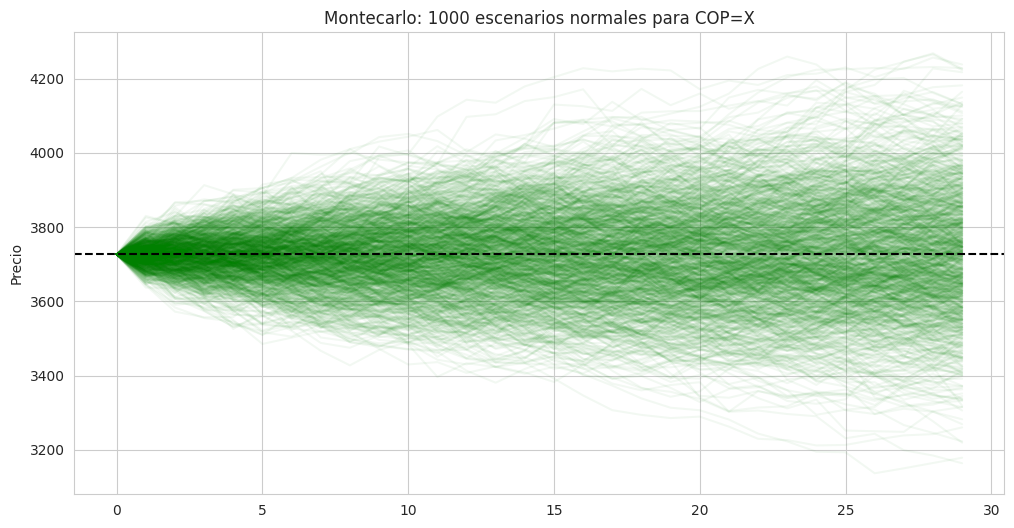

In [7]:
dias_proyeccion = 30
num_simulaciones = 1000

# Generar matriz de choques aleatorios
retornos_simulados = np.random.normal(mu, sigma, (dias_proyeccion, num_simulaciones))

# Matriz de precios
precios_simulados = np.zeros((dias_proyeccion, num_simulaciones))
precios_simulados[0] = ultimo_precio

for t in range(1, dias_proyeccion):
    precios_simulados[t] = precios_simulados[t-1] * np.exp(retornos_simulados[t])

plt.figure(figsize=(12, 6))
plt.plot(precios_simulados, color='green', alpha=0.05)
plt.axhline(ultimo_precio, color='black', linestyle='--', label='Precio Hoy')
plt.title(f"Montecarlo: {num_simulaciones} escenarios normales para {ticker}")
plt.ylabel("Precio")
plt.show()

### Interpretación

Lo que acabamos de generar no es arte abstracto, es una representación de la **Difusión de la Incertidumbre**.

1.  **El Embudo del Tiempo:**
    * Note cómo todas las líneas nacen juntas (hoy sabemos el precio exacto) y se van separando a medida que avanzan a la derecha.
    * Esto ilustra visualmente que **el riesgo aumenta con el tiempo**. Proyectar a mañana es fácil; proyectar a 30 días es un rango enorme. (Matemáticamente, la desviación estándar crece proporcional a $\sqrt{t}$).

2.  **Mapas de Calor de Probabilidad:**
    * Usamos `alpha=0.05` (transparencia) a propósito.
    * Las zonas donde el verde es **más intenso y oscuro** indican donde se solapan cientos de simulaciones. Esa es la zona de **Alta Probabilidad**.
    * Las líneas verdes tenues y solitarias en los extremos son los "Cisnes Negros" o eventos extremos poco probables.

3.  **Universos Paralelos:**
    * Cada línea es un "universo alternativo" válido matemáticamente. En uno, el dólar se disparó; en otro, se desplomó. Nosotros vivimos en solo uno de ellos, pero Montecarlo nos permite visitar los 1,000 antes de que sucedan.

### Análisis de Distribución Final (Value at Risk)

Ya vimos los caminos, ahora veamos a dónde llegaron. Este histograma nos dice cuál es la probabilidad de que el precio termine en cierto rango.

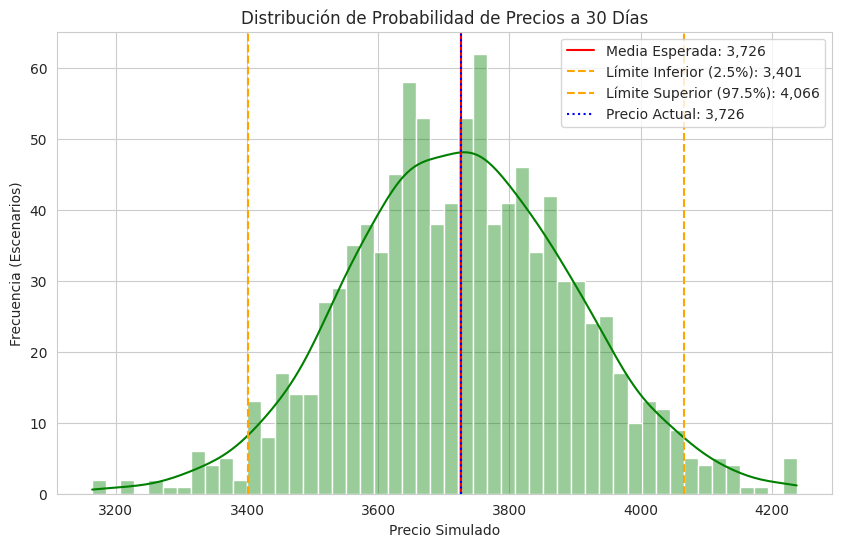

In [8]:
# Tomamos los precios finales (día 30) de todas las simulaciones
precios_finales = precios_simulados[-1]

# Intervalo de Confianza al 95%
limite_inferior = np.percentile(precios_finales, 2.5)
limite_superior = np.percentile(precios_finales, 97.5)
media_esperada = np.mean(precios_finales)

plt.figure(figsize=(10, 6))
sns.histplot(precios_finales, bins=50, kde=True, color='green', alpha=0.4)

# Líneas de referencia
plt.axvline(media_esperada, color='red', linestyle='-', label=f'Media Esperada: {media_esperada:,.0f}')
plt.axvline(limite_inferior, color='orange', linestyle='--', label=f'Límite Inferior (2.5%): {limite_inferior:,.0f}')
plt.axvline(limite_superior, color='orange', linestyle='--', label=f'Límite Superior (97.5%): {limite_superior:,.0f}')
plt.axvline(ultimo_precio, color='blue', linestyle=':', label=f'Precio Actual: {ultimo_precio:,.0f}')

plt.title(f"Distribución de Probabilidad de Precios a {dias_proyeccion} Días")
plt.xlabel("Precio Simulado")
plt.ylabel("Frecuencia (Escenarios)")
plt.legend()
plt.show()

### Distribución de Simulación

1.  **Simetría vs. Sesgo:**
    * Observa la forma de la campana. ¿Está centrada en el precio actual (línea azul punteda)?
    * Si la media roja está a la derecha del azul, el mercado tiene un sesgo alcista (Drift positivo). Si está a la izquierda, es bajista.

2.  **Gestión de Riesgo (VaR):**
    * Las líneas naranjas nos dan un **"Túnel de Confianza"** del 95%.
    * Podemos decir con un 95% de confianza que el precio **NO** caerá por debajo de la línea naranja izquierda. Esto es vital para coberturas financieras.

3.  **Colas:**
    * Fíjate en las barras pequeñas a los extremos. Esos son los escenarios extremos pero posibles. En gestión de riesgos, ignorar esas colas es lo que quiebra los fondos.

# Parte 3: Fusión - Markov aplicado al Dólar Real
### Extrayendo la matriz del mercado

Vamos a clasificar cada día del historial real en dos estados:
1. **UP (Subida):** El precio cerró más alto que ayer.
2. **DOWN (Bajada):** El precio cerró más bajo que ayer.

Matriz de Transición Real (Mercado Normal):
Estado_Manana      DOWN        UP
Estado_Hoy                       
DOWN           0.472119  0.527881
UP             0.570281  0.429719


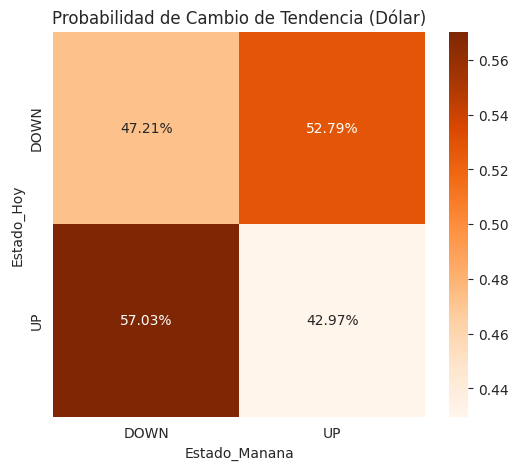

In [9]:
# 1. Crear los estados basados en retornos reales
df_estados = pd.DataFrame({'Retorno': log_returns})
df_estados['Estado_Hoy'] = np.where(df_estados['Retorno'] > 0, 'UP', 'DOWN')
df_estados['Estado_Manana'] = df_estados['Estado_Hoy'].shift(-1)
df_estados.dropna(inplace=True)

# 2. Calcular la Matriz de Transición Real
matriz_transicion_real = pd.crosstab(
    df_estados['Estado_Hoy'],
    df_estados['Estado_Manana'],
    normalize='index'
)

# Reordenar para asegurar consistencia [DOWN, UP] si es necesario, o usar nombres explícitos
# Aseguramos que el índice y columnas estén en orden DOWN, UP para consistencia matemática
matriz_transicion_real = matriz_transicion_real.reindex(index=['DOWN', 'UP'], columns=['DOWN', 'UP'])

print("Matriz de Transición Real (Mercado Normal):")
print(matriz_transicion_real)

plt.figure(figsize=(6, 5))
sns.heatmap(matriz_transicion_real, annot=True, cmap="Oranges", fmt=".2%")
plt.title("Probabilidad de Cambio de Tendencia (Dólar)")
plt.show()

### Interpretación con la Psicología del Mercado Real

Mira la matriz naranja de arriba. ¿Qué nos está gritando sobre el Dólar?

1.  **El Fenómeno "Zig-Zag" (Reversión a la Media):**
    * Fíjate en los cuadros fuera de la diagonal. Si hoy el mercado **BAJA**, hay una probabilidad del **52.8%** de que mañana **SUBA**.
    * Si hoy **SUBE**, hay un **57%** de probabilidad de que mañana **BAJE**.
    * **Insight:** Este mercado no tiene "memoria de tendencia" a corto plazo. Al contrario, tiende a corregirse. Si ves una subida fuerte hoy, la estadística dice "vende mañana".

2.  **Falta de Inercia (Momentum):**
    * Los valores en la diagonal (quedarse en el mismo estado) son menores al 50%.
    * Esto significa que es difícil que se formen rachas largas de subidas o bajadas consecutivas sin interrupción.

3.  **Conclusión para Trading:**
    * En este régimen, estrategias de **"Buy the Dip"** (comprar en la caída) tienen respaldo estadístico, ya que la probabilidad de rebote al día siguiente es alta.

# Parte 4: Stress Testing (Markov No Homogéneo)

En la Parte 3, la matriz era estática. Pero, **¿qué pasa si ocurre una crisis?**

Vamos a simular un escenario de **"Cisne Negro"**. Usaremos una Cadena de Markov No Homogénea donde las reglas cambian a mitad del camino.

### Escenario de Simulación:
* **Días 1-20:** Mercado Normal (Usamos la matriz real calculada arriba).
* **Días 21-30:** **CRISIS (Pánico):** La matriz cambia. La probabilidad de bajar aumenta drásticamente.
* **Días 31-50:** Recuperación (Volvemos a la matriz normal).

Esto se usa en la banca para medir si un portafolio aguanta un shock de mercado.

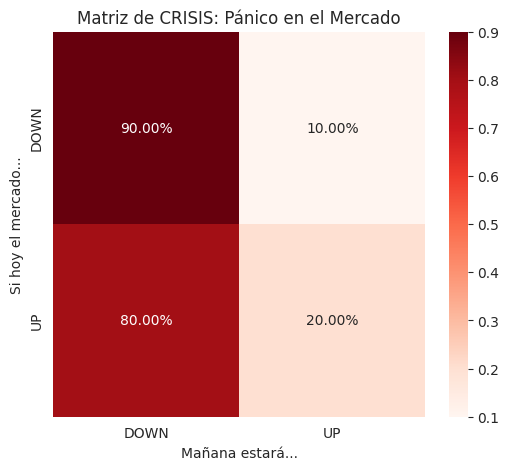

In [12]:
# 1. Definir las Matrices de los Regímenes

# Régimen Normal (Extraído de los datos)
P_normal = matriz_transicion_real.values

# Régimen de CRISIS (Pánico Financiero)
# En pánico, si baja, es MUY probable (90%) que siga bajando mañana.
# Si sube, es probable (80%) que sea un "rebote de gato muerto" y baje mañana.
P_crisis = np.array([
    [0.90, 0.10], # Si hoy baja -> 90% prob de seguir bajando (Pánico total)
    [0.80, 0.20]  # Si hoy sube -> 80% prob de volver a bajar
])

estados = ['DOWN', 'UP']

# Visualizar la Matriz de Crisis para comparar
plt.figure(figsize=(6, 5))
sns.heatmap(P_crisis, annot=True, cmap="Reds", fmt=".2%", xticklabels=estados, yticklabels=estados)
plt.title("Matriz de CRISIS: Pánico en el Mercado")
plt.ylabel("Si hoy el mercado...")
plt.xlabel("Mañana estará...")
plt.show()

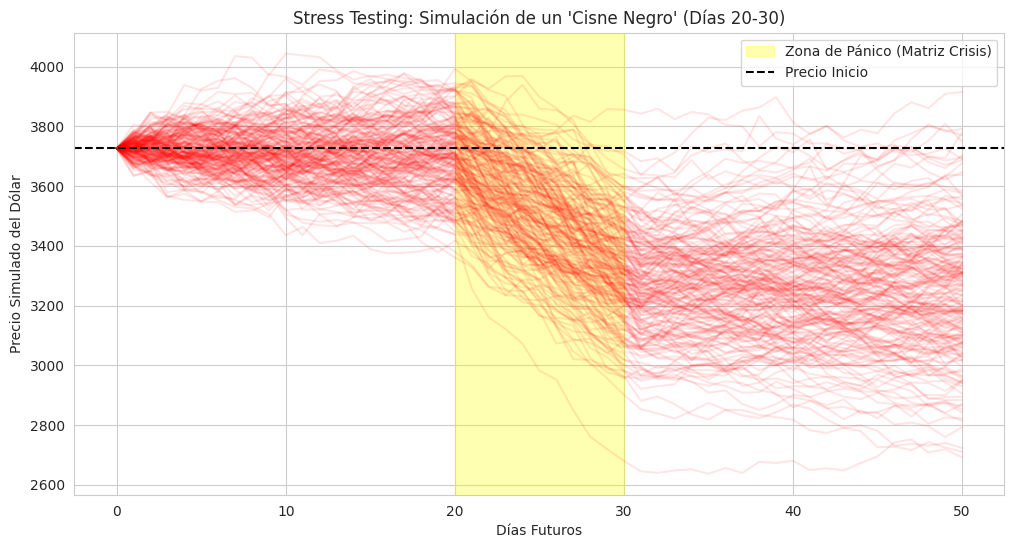

In [13]:
# 2. Función de Simulación con Cambio de Régimen
def simular_stress_test(dias_totales=50, inicio_crisis=20, fin_crisis=30):
    historial_estados = []
    historial_precios = [ultimo_precio]

    # Estado inicial aleatorio basado en el último día real
    estado_actual_idx = 0 if log_returns.iloc[-1] < 0 else 1 # 0=DOWN, 1=UP

    precio_simulado = ultimo_precio

    for t in range(dias_totales):
        # --- Lógica No Homogénea: Seleccionar Matriz según el día ---
        if inicio_crisis <= t <= fin_crisis:
            matriz_actual = P_crisis
            regimen = "CRISIS"
        else:
            matriz_actual = P_normal
            regimen = "NORMAL"

        # Determinar el siguiente estado (UP o DOWN) lanzando el dado
        probs = matriz_actual[estado_actual_idx]
        nuevo_estado_idx = np.random.choice([0, 1], p=probs)

        # Calcular el impacto en el precio
        # Si es UP, sube un % aleatorio (promedio positivo)
        # Si es DOWN, baja un % aleatorio (promedio negativo)
        if nuevo_estado_idx == 1: # UP
            retorno_dia = np.abs(np.random.normal(mu, sigma)) # Forzamos positivo
        else: # DOWN
            # En crisis, las bajadas son más fuertes (Volatilidad x 2)
            vol_factor = 2.0 if regimen == "CRISIS" else 1.0
            retorno_dia = -np.abs(np.random.normal(mu, sigma * vol_factor)) # Forzamos negativo

        precio_simulado = precio_simulado * np.exp(retorno_dia)

        historial_precios.append(precio_simulado)
        historial_estados.append(estados[nuevo_estado_idx])
        estado_actual_idx = nuevo_estado_idx

    return historial_precios

# 3. Ejecutar Simulaciones Masivas
simulaciones_stress = []
for _ in range(200): # 200 escenarios
    simulaciones_stress.append(simular_stress_test())

simulaciones_stress = np.array(simulaciones_stress)

# 4. Visualizar el Impacto del Shock
plt.figure(figsize=(12, 6))

# Graficar todas las simulaciones
for sim in simulaciones_stress:
    plt.plot(sim, color='red', alpha=0.1)

# Resaltar la zona de crisis
plt.axvspan(20, 30, color='yellow', alpha=0.3, label='Zona de Pánico (Matriz Crisis)')
plt.axhline(ultimo_precio, color='black', linestyle='--', label='Precio Inicio')

plt.title("Stress Testing: Simulación de un 'Cisne Negro' (Días 20-30)")
plt.xlabel("Días Futuros")
plt.ylabel("Precio Simulado del Dólar")
plt.legend()
plt.show()

### Análisis del "Cisne Negro"

1.  **El "Hoyo Negro" de la Crisis:**
    * Observa el gráfico de calor rojo arriba. La celda **DOWN -> DOWN es del 90%**.
    * Esto significa que una vez que el mercado entra en crisis, es extremadamente difícil salir. Se convierte en un "estado pegajoso" o casi absorbente.

2.  **Impacto en el Precio (Zona Amarilla):**
    * En el gráfico de líneas, ve cómo la tendencia lateral se rompe violentamente en el día 20.
    * Incluso cuando la crisis termina en el día 30 y volvemos a la matriz "Normal", **el daño ya está hecho**. El precio no se recupera automáticamente; simplemente deja de caer tan rápido.
    * **Lección de Riesgo:** Las crisis son eventos de "cola grasa" que destruyen valor mucho más rápido de lo que se puede crear.

# Parte 5: Predicción Analítica

Hasta ahora hemos usado **fuerza bruta** (Simulación) para ver qué pasa. Pero las Cadenas de Markov tienen una propiedad mágica: permiten calcular el futuro **exacto** usando potencias de matrices.

Si $P$ es la matriz de transición de 1 día, entonces $P^n$ (P elevado a la n) contiene las probabilidades exactas de transición para $n$ días.

**Pregunta de Negocio:**
*"Si hoy el mercado cerró a la BAJA (DOWN), ¿cuál es la probabilidad exacta de que en 7 días esté AL ALZA (UP)?"*

No necesitamos simular 10,000 veces. Solo necesitamos multiplicar la matriz.

Matriz P (1 día):
 [[0.47211896 0.52788104]
 [0.57028112 0.42971888]]

Matriz P^7 (Proyección a 1 semana):
          Futuro DOWN  Futuro UP
Hoy DOWN     0.519305   0.480695
Hoy UP       0.519305   0.480695

Matriz P^30 (Proyección a 1 mes):
          Futuro DOWN  Futuro UP
Hoy DOWN     0.519305   0.480695
Hoy UP       0.519305   0.480695


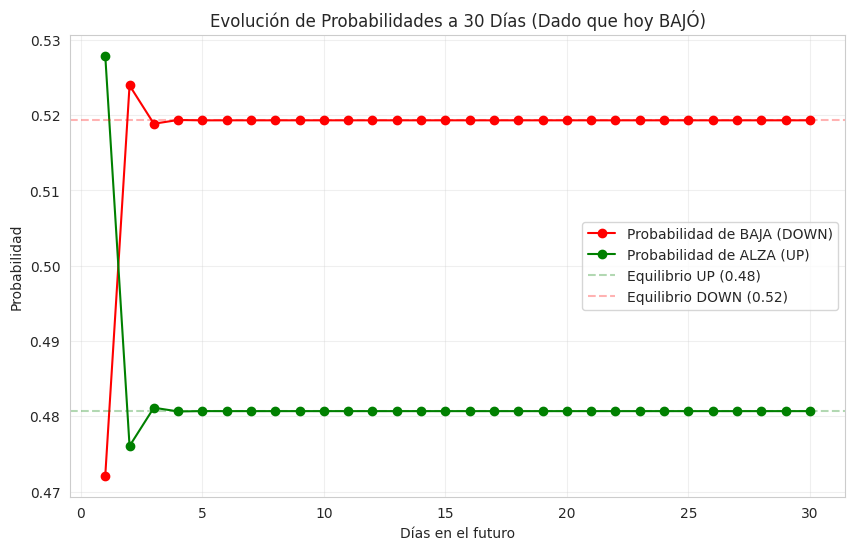

In [14]:
# 1. Obtener la matriz P de datos reales (Normalizada)
P = matriz_transicion_real.values
print("Matriz P (1 día):\n", P)

# 2. Calcular P elevado a la 7 (Proyección a 7 días)
P_7 = np.linalg.matrix_power(P, 7)

print("\nMatriz P^7 (Proyección a 1 semana):")
print(pd.DataFrame(P_7, index=['Hoy DOWN', 'Hoy UP'], columns=['Futuro DOWN', 'Futuro UP']))

# 3. Calcular P elevado a la 30 (Proyección a 1 mes)
P_30 = np.linalg.matrix_power(P, 30)

print("\nMatriz P^30 (Proyección a 1 mes):")
print(pd.DataFrame(P_30, index=['Hoy DOWN', 'Hoy UP'], columns=['Futuro DOWN', 'Futuro UP']))

# 4. Visualización de la Convergencia Analítica
# Inicializamos AMBAS listas vacías (Aquí estaba el error)
prob_up_given_down = []
prob_down_given_down = []  # <--- ESTA LÍNEA FALTABA

n_dias = 30

# Calculamos las probabilidades para cada día de 1 a 30
for n in range(1, n_dias + 1):
    P_n = np.linalg.matrix_power(P, n)

    # Dado que empezamos en DOWN (índice 0):
    prob_down = P_n[0, 0] # Probabilidad de seguir en DOWN
    prob_up = P_n[0, 1]   # Probabilidad de cambiar a UP

    prob_down_given_down.append(prob_down)
    prob_up_given_down.append(prob_up)

# Crear gráfico de evolución
plt.figure(figsize=(10, 6))
dias = range(1, n_dias + 1)



plt.plot(dias, prob_down_given_down, marker='o', linestyle='-', color='red', label='Probabilidad de BAJA (DOWN)')
plt.plot(dias, prob_up_given_down, marker='o', linestyle='-', color='green', label='Probabilidad de ALZA (UP)')

plt.title("Evolución de Probabilidades a 30 Días (Dado que hoy BAJÓ)")
plt.xlabel("Días en el futuro")
plt.ylabel("Probabilidad")
# Añadimos la línea de equilibrio asintótico
plt.axhline(y=prob_up_given_down[-1], color='green', linestyle='--', alpha=0.3, label=f'Equilibrio UP ({prob_up_given_down[-1]:.2f})')
plt.axhline(y=prob_down_given_down[-1], color='red', linestyle='--', alpha=0.3, label=f'Equilibrio DOWN ({prob_down_given_down[-1]:.2f})')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Interpretación Final

1. **Corto Plazo (Día 1-5):** La curva se mueve bruscamente. El hecho de que hoy haya bajado influye mucho en el mañana.
2. **Largo Plazo (Día 20+):** La curva se aplana. El sistema "olvida" el estado inicial.
3. **Conclusión:** A largo plazo, la probabilidad de que el dólar suba tiende a un número fijo (ej. 52%), sin importar si hoy hubo un crash o un boom. Esto confirma matemáticamente lo que vimos en la simulación de Montecarlo.